In [1]:
city   = 'london'
infile = '../ProcessedData/' + city + '/venues_info/venues_time_series.dat'

import os
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas as pd
from scipy.stats import spearmanr
from collections import Counter

def getDistribution(keys, normalized = True):
    
    uniq_keys = np.unique(keys)
    bins = uniq_keys.searchsorted(keys)
    distr = np.bincount(bins) 

    if normalized == 1: distr = distr/float(np.sum(distr)) 

    return np.asarray(uniq_keys.tolist()), np.asarray(distr.tolist())

def round_unix_date(dt_series, seconds=60, up=False):
    return dt_series // seconds * seconds + seconds * up


## READ THE TIMESERIES

In [2]:
def get_venues_times(infile):

    venues_times = {}
    longest = {}

    for ind, line in enumerate(open(infile)):

        #if ind == 10: break
        fields = line.strip().split('\t')
        venue  = fields[0]
        #times  = sorted([ datetime.datetime.fromtimestamp(float(fff)).strftime('%Y-%m-%d %H:%M:%S') for fff in fields[1:]])
        times  = sorted([ round_unix_date(float(fff), 3*30*24*60*60) for fff in fields[1:]])

        x, y = zip(* sorted([(k, v) for k, v in dict(Counter(times)).items()], key=lambda tup: tup[0]))
        
        
        venues_times[venue] = (x,y)
        
        if len(times) > 100:
              longest[venue] = (x,y)


    return venues_times, longest
    
    
    
def get_avg_counts(infile):

    times_count = {}

    for ind, line in enumerate(open(infile)):

        times  = [ round_unix_date(float(fff), 3*30*24*60*60) for fff in line.strip().split('\t')[1:]]
        for time in times:
            if time not in times_count:
                times_count[time] = 1
            else:
                times_count[time] += 1
        


    return times_count    
    
    
    
venues_times, longest = get_venues_times(infile)
avg_times_count       = get_avg_counts(infile)



## MEASURE = LIKES from londoners

Text(0,0.5,'pdf')

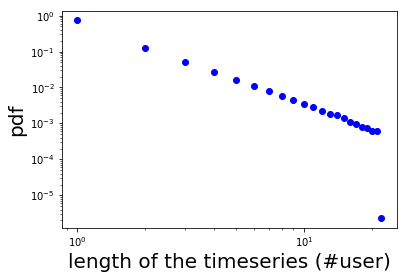

In [20]:
length = [len(t) for tt,t in venues_times.values()]
x, y   = getDistribution(length)

plt.plot(x,y, 'bo')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('length of the timeseries (#user)', fontsize = 20) 
plt.ylabel('pdf', fontsize = 20)

Text(0.5,1,'Monthly like count for the venues w > 100 likes')

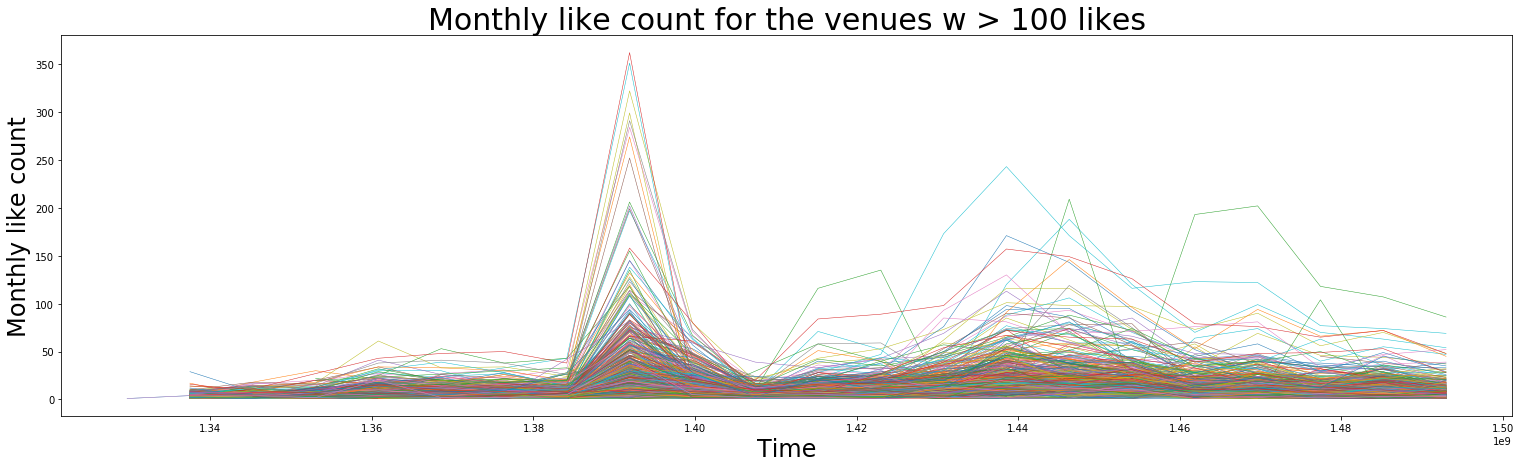

In [3]:
f, ax = plt.subplots(1, 1, figsize=(26, 7))


for ind, (ven, times) in enumerate(longest.items()):
    #print ind,   times[0], datetime.datetime.fromtimestamp(int(times[0])).strftime('%Y-%m-%d %H:%M:%S'), round_unix_date(times[0], 24*60*60), 
    
    #tt = datetime.datetime.fromtimestamp(round_unix_date(times[0], 24*60*60, up = False)).strftime('%Y-%m-%d %H:%M:%S')
    #if ind == 50: break
    #print ind, tt
    ax.plot(times[0], times[1], '-', linewidth = 0.5)
    
ax.set_xlabel('Time',fontsize = 24)
ax.set_ylabel('Monthly like count',fontsize = 24)
ax.set_title('Monthly like count for the venues w > 100 likes', fontsize = 30)
    


## HOW THE LONDONERS LIKES CORRELATE TO THE WHOLE

In [22]:
''' LONDON LIKE COUNT VS ALL'''
venues_likes_full   = {}
venues_likes_london = {}


for ind, line in enumerate(open('../ProcessedData/' + city + '/venues_info/london_liked_venues_stats.dat')):
    #if ind == 10: break
    ven, meas = line.strip().split('\t')
    venues_likes_full[ven] = int(meas.split(', ')[0].split(': ')[1])
    
for ind, (ven, times) in enumerate(venues_times.items()):
    #if ind == 100: break
    if sum(times[1]) > 100:
        venues_likes_london[ven] = sum(times[1]) 

print len(venues_likes_full)  
print len(venues_likes_london)  

430460
747


In [23]:
x, y = zip(*[(venues_likes_full[ven], cnt) for ven, cnt in venues_likes_london.items()])

Text(0.5,1,'SpearmanR = 0.456')

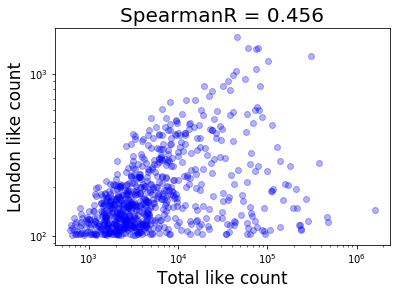

In [24]:
plt.plot(x,y, 'bo', alpha = 0.3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Total like count', fontsize = 17)
plt.ylabel('London like count', fontsize = 17)
plt.title('SpearmanR = ' + str(round(spearmanr(x,y)[0], 3)), fontsize = 20)


Text(0.5,1,'London like count pdf')

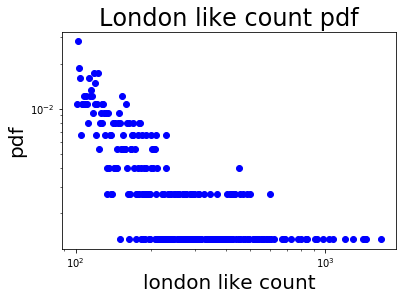

In [25]:
xx, yy = getDistribution(y, normalized = True)
plt.plot(xx, yy, 'bo')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('london like count', fontsize = 20) 
plt.ylabel('pdf', fontsize = 20)
plt.title('London like count pdf', fontsize = 24)

# AVERAGING STUFF

In [9]:
avg_times_count = get_avg_counts(infile)
total_avg       = np.mean(avg_times_count.values())
total_avg

51684.13043478261

Text(0.5,1,'Monthly likecount in London')

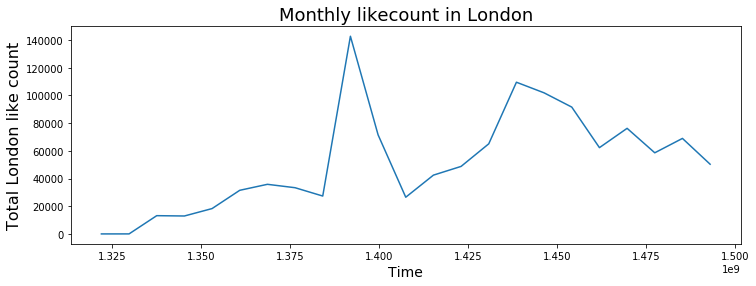

In [27]:
f, ax = plt.subplots(1, 1, figsize=(12, 4))

x, y = zip(* sorted([(k, v) for k, v in dict(Counter(avg_times_count)).items()], key=lambda tup: tup[0]))

ax.plot(x, y)
ax.set_xlabel('Time', fontsize = 14)
ax.set_ylabel('Total London like count', fontsize = 16)
ax.set_title('Monthly likecount in London', fontsize = 18)

# RENORMALIZE CAREERS

In [10]:
venues_times_norm     = {}
venues_times_norm_lng = {}

for ind, (ven, (times, cnts)) in enumerate(venues_times.items()):
    
    #if ind == 100: break
         
    for i in range(len(times)):
        
        normcnt  = float(cnts[i]) / avg_times_count[times[i]] * total_avg
        
        if ven not in venues_times_norm:
            venues_times_norm[ven] = [(times[i], normcnt)]
        else:
            venues_times_norm[ven].append((times[i], normcnt))
            
        if ven in longest:
            
            if ven not in venues_times_norm_lng:
                venues_times_norm_lng[ven] = [(times[i], normcnt)]
            else:
                venues_times_norm_lng[ven].append((times[i], normcnt))
        

    

In [47]:
outfolder        = '../ProcessedData/' + city + '/'
relevant_venues  = list(set([line.strip().split('\t')[0] for line in open(outfolder + '/venues_info/venues_ward_full.dat') if 'venue' not in line]))
infile           = '../ProcessedData/' + city + '/venues_info/venues_time_series.dat'
venues_here      = list(set(venues_times_norm.keys()).intersection(set(relevant_venues)))
local_success    = {}


for ind, venue in enumerate(venues_here):
    #if ind == 10: break
    local_success[venue] = sum(zip(*venues_times_norm[venue])[1])
     

df = pd.DataFrame.from_dict(local_success, orient = 'index', columns = ['Llikecount'])
df.to_csv(outfolder + 'venues_info/' + city + '_venues_success_measures_local_like.csv' , sep = '\t')
    

In [12]:
all_times = sorted(avg_times_count.keys())
print all_times
for ind, (ven, times) in enumerate(venues_times_norm_lng.items()):
    
    if ind == 10: break
        
    time, cnt = zip(*[(t, c) for (t, c) in times if c < 1000 and t > 1347840000])
    
    mint = min(time)
    
    time_x = []
    cnt_x  = []
    
    for ind, t in enumerate(all_times):
        
        if t > mint:
            
            if t in time:
                time_x.append(t)
                cnt_x.append(cnt[time.index(t)])
                
            else:
                time_x.append(t)
                cnt_x.append(0)


[1321920000.0, 1329696000.0, 1337472000.0, 1345248000.0, 1353024000.0, 1360800000.0, 1368576000.0, 1376352000.0, 1384128000.0, 1391904000.0, 1399680000.0, 1407456000.0, 1415232000.0, 1423008000.0, 1430784000.0, 1438560000.0, 1446336000.0, 1454112000.0, 1461888000.0, 1469664000.0, 1477440000.0, 1485216000.0, 1492992000.0]


Counter({20: 438, 19: 112, 18: 56, 17: 33, 15: 18, 12: 15, 14: 15, 16: 13, 13: 11, 8: 8, 9: 8, 10: 7, 11: 7, 6: 2, 7: 2, 2: 1, 4: 1})


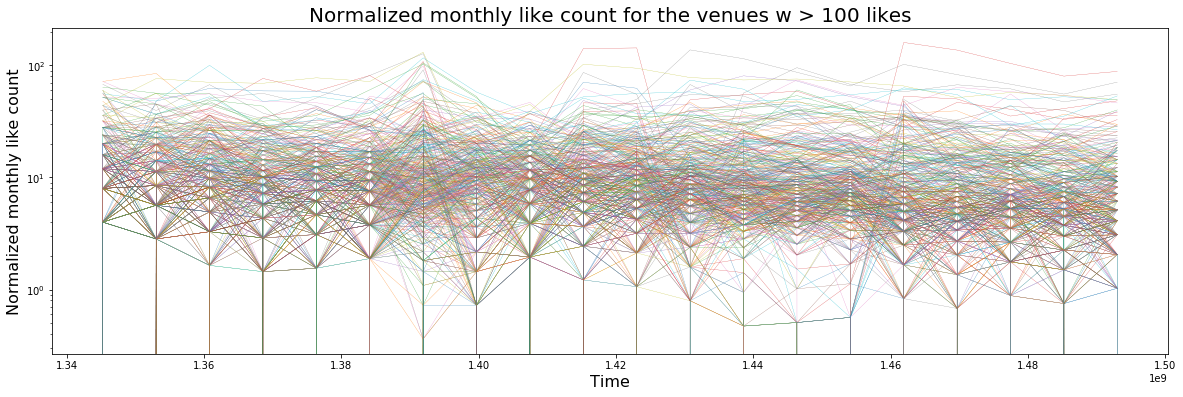

In [13]:
f, ax = plt.subplots(1, 1, figsize=(20, 6))
lengths = []

#time_series = pd.DataFrame()
time_series = []

for ind, (ven, times) in enumerate(venues_times_norm_lng.items()):

    #if ind == 200: break
     
    time, cnt = zip(*[(t, c) for (t, c) in times if c < 1000 ])
    mint = min(time)
    
    time_x = []
    cnt_x  = []
    
    for ind, t in enumerate(all_times):
        
        if t > mint:
            
            if t in time:
                time_x.append(t)
                cnt_x.append(cnt[time.index(t)])
                
            else:
                time_x.append(t)
                cnt_x.append(0)
    

 
    lengths.append(len(cnt_x))
    #if ind > 11 and ind < 20:
    #    ax.plot(x, y, '-', linewidth = 3.125)
    if len(cnt_x) == 20:
        #time_series[ven] = cnt_x
        time_series.append(cnt_x)
        ax.plot(time_x, cnt_x, '-', linewidth = 0.225)
    
#ax.set_ylim([0,125])
ax.set_yscale('log')
ax.set_xlabel('Time',fontsize = 16)
ax.set_ylabel('Normalized monthly like count',fontsize = 16)
ax.set_title('Normalized monthly like count for the venues w > 100 likes', fontsize = 20)
    
print Counter(lengths)

# GET SIMILARITY MATRICES

In [31]:
from scipy.stats import kendalltau
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import pandas as pd

In [32]:
def organizemtx(C):
    
    # This generates 100 variables that could possibly be assigned to 5 clusters
    n_variables = len(C[0])
    n_clusters = 5
    n_samples = 1000

    cluster_size = n_variables / n_clusters
    belongs_to_cluster = np.repeat(range(n_clusters), cluster_size)
    np.random.shuffle(belongs_to_cluster)

    latent = np.random.randn(n_clusters, n_samples)

    def score(C):
        score = 0
        for cluster in range(n_clusters):
            inside_cluster = np.arange(cluster_size) + cluster * cluster_size
            outside_cluster = np.setdiff1d(range(n_variables), inside_cluster)
            score += np.sum(C[inside_cluster, :][:, inside_cluster])
            score -= np.sum(C[inside_cluster, :][:, outside_cluster])
            score -= np.sum(C[outside_cluster, :][:, inside_cluster])

        return score


    initial_C = C
    initial_score = score(C)
    initial_ordering = np.arange(n_variables)

    plt.figure()
    plt.imshow(C, interpolation='nearest')
    plt.title('Initial C')
   
    def swap_rows(C, var1, var2):
        '''
        Function to swap two rows in a covariance matrix,
        updating the appropriate columns as well.
        '''
        D = C.copy()
        D[var2, :] = C[var1, :]
        D[var1, :] = C[var2, :]

        E = D.copy()
        E[:, var2] = D[:, var1]
        E[:, var1] = D[:, var2]

        return E

    current_C = C
    current_ordering = initial_ordering
    current_score = initial_score

    max_iter = 1000
    for i in range(max_iter):
        # Find the best row swap to make
        best_C = current_C
        best_ordering = current_ordering
        best_score = current_score
        for row1 in range(n_variables):
            for row2 in range(n_variables):
                if row1 == row2:
                    continue
                option_ordering = best_ordering.copy()
                option_ordering[row1] = best_ordering[row2]
                option_ordering[row2] = best_ordering[row1]
                option_C = swap_rows(best_C, row1, row2)
                option_score = score(option_C)

                if option_score > best_score:
                    best_C = option_C
                    best_ordering = option_ordering
                    best_score = option_score

        if best_score > current_score:
            # Perform the best row swap
            current_C = best_C
            current_ordering = best_ordering
            current_score = best_score
        else:
            # No row swap found that improves the solution, we're done
            break

    # Output the result
    plt.figure()
    plt.imshow(current_C, interpolation='nearest')
    plt.title('Best C')


In [ ]:
corr_K = np.zeros(shape=(len(time_series),len(time_series)))
for i, t1 in enumerate(time_series):
    for j, t2 in enumerate(time_series):
        K = kendalltau(t2, t1)
        corr_K[i,j] = K[0]
        
organizemtx(corr_K)

In [ ]:
corr_S = np.zeros(shape=(len(time_series),len(time_series)))
for i, t1 in enumerate(time_series):
    for j, t2 in enumerate(time_series):
        S = spearmanr(t2, t1)
        corr_S[i,j] = S[0]
        
organizemtx(corr_S)

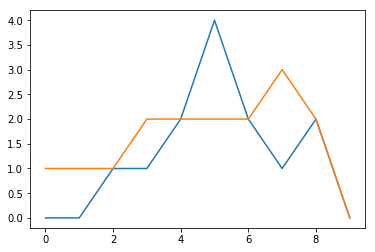

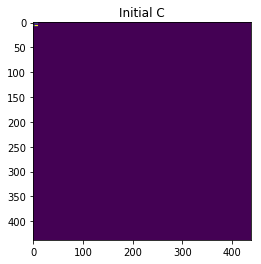

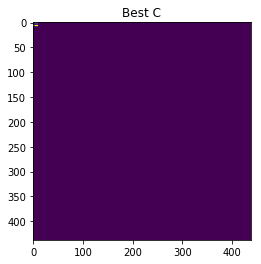

In [38]:
import numpy as np
from dtw import dtw
import matplotlib.pyplot as plt
from numpy.linalg import norm


distwt = np.zeros(shape=(len(time_series),len(time_series)))

x = np.array([0, 0, 1, 1, 2, 4, 2, 1, 2, 0]).reshape(-1, 1)
y = np.array([1, 1, 1, 2, 2, 2, 2, 3, 2, 0]).reshape(-1, 1)

plt.plot(x)
plt.plot(y)

for i, t1 in enumerate(time_series[0:10]):
    for j, t2 in enumerate(time_series[0:10]):
        dist, cost, acc, path = dtw(np.array(t1).reshape(-1, 1), np.array(t2).reshape(-1, 1), dist=norm)
        distwt[i,j] = dist
        
organizemtx(distwt)

In [15]:
clustered_venues = [line.strip() for line in open('clustered_series')]

Counter({20: 88})


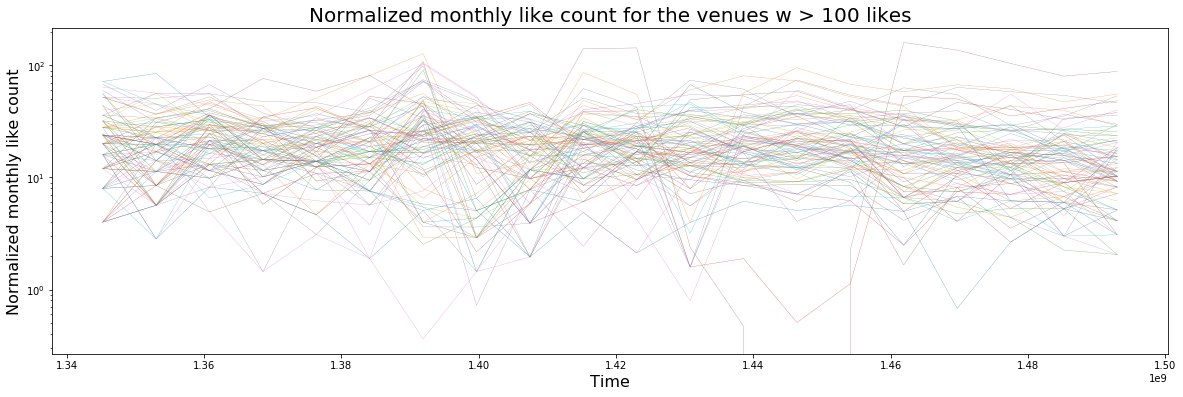

In [18]:
f, ax = plt.subplots(1, 1, figsize=(20, 6))
lengths = []

#time_series = pd.DataFrame()
time_series = []

for ind, (ven, times) in enumerate(venues_times_norm_lng.items()):

    #if ind == 200: break
    if ven in clustered_venues:
        
        time, cnt = zip(*[(t, c) for (t, c) in times if c < 1000 ])
        mint = min(time)

        time_x = []
        cnt_x  = []

        for ind, t in enumerate(all_times):

            if t > mint:

                if t in time:
                    time_x.append(t)
                    cnt_x.append(cnt[time.index(t)])

                else:
                    time_x.append(t)
                    cnt_x.append(0)



        lengths.append(len(cnt_x))
        #if ind > 11 and ind < 20:
        #    ax.plot(x, y, '-', linewidth = 3.125)
        if len(cnt_x) == 20:
            #time_series[ven] = cnt_x
            time_series.append(cnt_x)
            ax.plot(time_x, cnt_x, '-', linewidth = 0.225)
    
#ax.set_ylim([0,125])
ax.set_yscale('log')
ax.set_xlabel('Time',fontsize = 16)
ax.set_ylabel('Normalized monthly like count',fontsize = 16)
ax.set_title('Normalized monthly like count for the venues w > 100 likes', fontsize = 20)
    
print Counter(lengths)